# Comparaison des différentes méthodes pour la super résolution d'images

## I Importation des bibliothèques nécessaires

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import zipfile
import os
from src.ref.linear_interpolation import LinearInterpolation
from src.ref.bilinear_interpolation import BilinearInterpolation
from src.ref.bicubic_interpolation import BicubicInterpolation

## II Téléchargement d'un dataset

In [2]:
!wget --no-check-certificate --no-clobber \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

# Extracting zip file to the base directory `/tmp/cats_and_dogs_filtered`
local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'validation')

# Directories with training/validation cat/dogs pictures
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
valid_cats_dir = os.path.join(valid_dir, 'cats')
valid_dogs_dir = os.path.join(valid_dir, 'dogs')

# Display the sizes of our dataset
print(f'Number of train cat images: {len(os.listdir(train_cats_dir))}')
print(f'Number of train dog images: {len(os.listdir(train_dogs_dir))}')
print(f'Number of valid cat images: {len(os.listdir(valid_cats_dir))}')
print(f'Number of valid dog images: {len(os.listdir(valid_dogs_dir))}')

# Display some images files for cats and dogs
train_cat_fnames = os.listdir(train_cats_dir)
print(train_cat_fnames[:10])

File ‘/tmp/cats_and_dogs_filtered.zip’ already there; not retrieving.
Number of train cat images: 1000
Number of train dog images: 1000
Number of valid cat images: 500
Number of valid dog images: 500
['cat.469.jpg', 'cat.977.jpg', 'cat.580.jpg', 'cat.324.jpg', 'cat.762.jpg', 'cat.506.jpg', 'cat.419.jpg', 'cat.772.jpg', 'cat.996.jpg', 'cat.491.jpg']


## III Affichage de quelques exemples

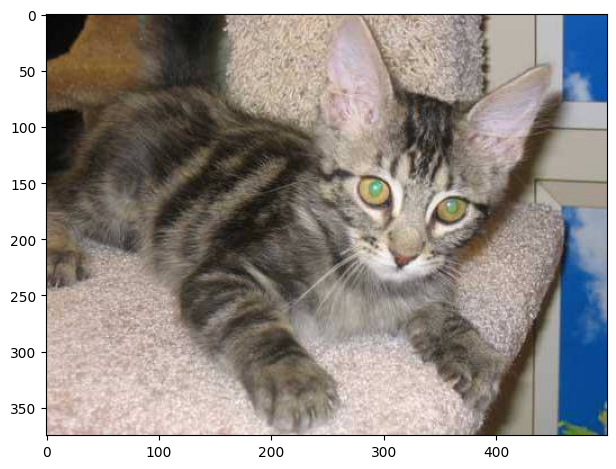

In [3]:
c = np.random.randint(len(os.listdir(train_cats_dir)))
cat = cv2.imread(train_cats_dir + '/' + train_cat_fnames[c])

# color are inverted
cat = cv2.cvtColor(cat, cv2.COLOR_BGR2RGB)

plt.imshow(cat)
plt.tight_layout()

## IV Test des différentes métriques

In [4]:
from src.ref.metrics import Metric
from src.ref.damage_image import Damager
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

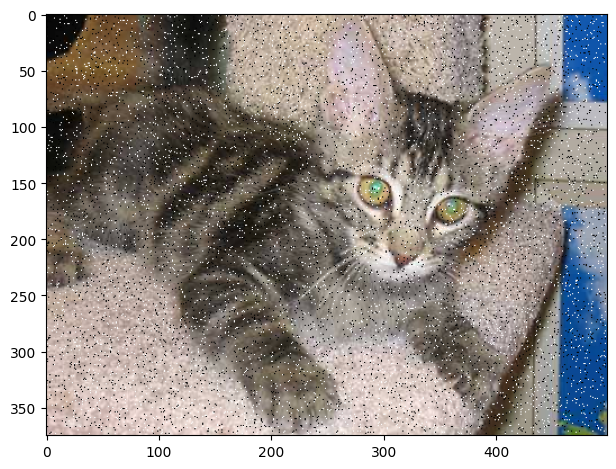

In [5]:
new_image = Damager.add_salt_and_pepper_noise(cat, 0.01, 0.01)

# Plot the damage cat
plt.imshow(new_image)
plt.tight_layout()


In [6]:
rng = np.linspace(0, 0.1, 100)

our_psnr = []
skimage_psnr = []

out_psnr_float = []
skimage_psnr_float = [] 

our_ssim_1 = []
our_ssim_2 = []
skimage_ssim = []

for i in range(0, len(rng)):
    new_image = Damager.add_salt_and_pepper_noise(cat, rng[i])
    
    our_psnr.append(Metric.PSNR(cat, new_image))

    # add little value to avoid same curve in the plot
    skimage_psnr.append(peak_signal_noise_ratio(cat, new_image))

    out_psnr_float.append(Metric.PSNR(cat.astype(float) / 255, new_image.astype(float)  / 255))
    skimage_psnr_float.append(peak_signal_noise_ratio(cat.astype(float)  / 255, new_image.astype(float)  / 255))
    
    our_ssim_1.append(Metric.SSIM(cat, new_image))
    our_ssim_2.append(Metric.SSIM_2(cat, new_image))
    skimage_ssim.append(structural_similarity(cat, new_image, win_size=3, multichannel=False))

    # Print advancement
    if i % 10 == 0:
        print(f'Advancement: {i}/{len(rng)}')


Advancement: 0/100
Advancement: 10/100
Advancement: 20/100
Advancement: 30/100
Advancement: 40/100
Advancement: 50/100
Advancement: 60/100
Advancement: 70/100
Advancement: 80/100
Advancement: 90/100


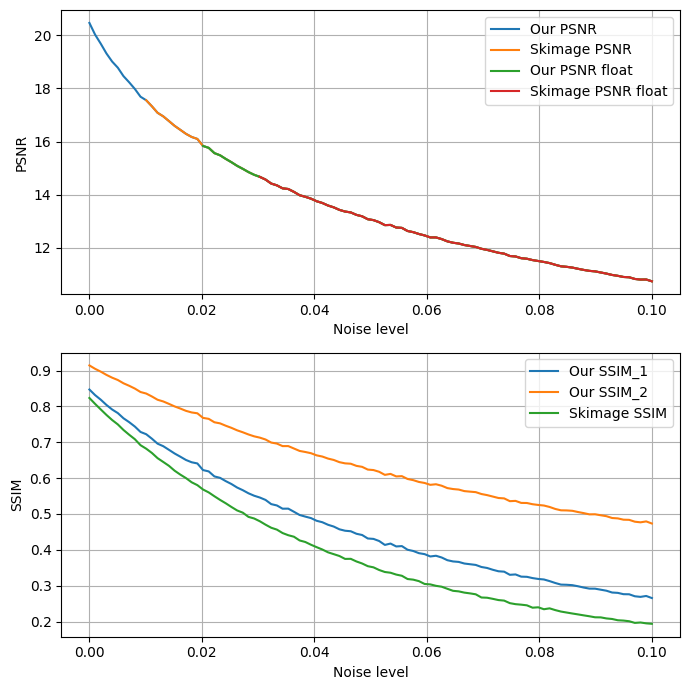

In [7]:
  
# Do two sub plots and plot the results (psnr for on case and ssim_1, ssim_2 for the other)
fig, axs = plt.subplots(2, 1, figsize=(7, 7))
axs[0].plot(rng, our_psnr, label='Our PSNR')
axs[0].plot(rng[10:], skimage_psnr[10:], label='Skimage PSNR')

axs[0].plot(rng[20:], out_psnr_float[20:], label='Our PSNR float')
axs[0].plot(rng[30:], skimage_psnr_float[30:], label='Skimage PSNR float')

axs[0].set_xlabel('Noise level')
axs[0].set_ylabel('PSNR')
axs[0].legend()
axs[0].grid()

axs[1].plot(rng, our_ssim_1, label='Our SSIM_1')
axs[1].plot(rng, our_ssim_2, label='Our SSIM_2')
axs[1].plot(rng, skimage_ssim, label='Skimage SSIM')
axs[1].set_xlabel('Noise level')
axs[1].set_ylabel('SSIM')
axs[1].legend()
axs[1].grid()

plt.tight_layout()
plt.show()


In [8]:
# Show mean both mean diff and variance between SSIM_2 and SSIM from skimage

print(f'Mean diff between SSIM_2 and SSIM from skimage: {np.mean(np.array(our_ssim_1) - np.array(skimage_ssim))}')
print(f'Variance diff between SSIM_2 and SSIM from skimage: {np.var(np.array(our_ssim_1) - np.array(skimage_ssim))}')

# Show mean both mean diff and variance between PSNR and PSNR from skimage

print(f'Mean diff between PSNR and PSNR from skimage: {np.mean(np.array(our_psnr) - np.array(skimage_psnr))}')
print(f'Variance diff between PSNR and PSNR from skimage: {np.var(np.array(our_psnr) - np.array(skimage_psnr))}')

Mean diff between SSIM_2 and SSIM from skimage: 0.06800872579789552
Variance diff between SSIM_2 and SSIM from skimage: 0.0002705342622839159
Mean diff between PSNR and PSNR from skimage: 3.552713678800501e-17
Variance diff between PSNR and PSNR from skimage: 1.9551128674997558e-30


In [9]:
from src.ref.image_reduction import Reducer
import src.ref.bilinear_interpolation as bilinear
import src.ref.bicubic_interpolation as bicubic
import src.ref.linear_interpolation as linear

# Create a new image reduction object
image = cv2.imread("resources/set14/baboon.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (256, 256))

low_image = cv2.resize(image, (128, 128))

resized_image_bilinear = bilinear.BilinearInterpolation(low_image, 2)
resized_image_bicubic = bicubic.BicubicInterpolation(low_image, 2)
resized_image_linear = linear.LinearInterpolation(low_image, 2)

from src.ref.metrics import Metric

print(f'PSNR Bilinear: {Metric.PSNR(image, resized_image_bilinear)}')
print(f'PSNR Bicubic: {Metric.PSNR(image, resized_image_bicubic)}')
print(f'PSNR Linear: {Metric.PSNR(image, resized_image_linear)}')

print(f'SSIM Bilinear: {Metric.SSIM(image, resized_image_bilinear)}')
print(f'SSIM Bicubic: {Metric.SSIM(image, resized_image_bicubic)}')
print(f'SSIM Linear: {Metric.SSIM(image, resized_image_linear)}')

# Show original, reduced and the three resized image in same plot
# original and reduced on top row
# bilinear, bicubic and linear on bottom row
fig, axs = plt.subplots(2, 3, figsize=(15, 15))
axs[0, 0].imshow(image)
axs[0, 0].set_title('Original')

axs[0, 1].imshow(low_image)
axs[0, 1].set_title('Reduced')

axs[1, 0].imshow(resized_image_bilinear)
axs[1, 0].set_title('Bilinear')

axs[1, 1].imshow(resized_image_bicubic)
axs[1, 1].set_title('Bicubic')

axs[1, 2].imshow(resized_image_linear)
axs[1, 2].set_title('Linear')

plt.show()

[ WARN:0@11.271] global loadsave.cpp:248 findDecoder imread_('resources/set14/baboon.png'): can't open/read file: check file path/integrity


error: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'
